In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid, inset_locator, make_axes_locatable
from mne.decoding import ReceptiveField
from sklearn.linear_model import Ridge

import mne

In [2]:
file_path = '/users/e4/E-2/DEAP_DATA/s10.dat'
data = np.fromfile(file_path, dtype=np.float32)

n_channels = 40
n_time_points = 8064
n_trials = len(data) // (n_channels * n_time_points)
data = data[:n_trials * n_channels * n_time_points].reshape(n_trials, n_channels, n_time_points)
subset = data[:10]
print (subset.shape)

(10, 40, 8064)


In [3]:
if np.isnan(subset).any() or np.isinf(subset).any():
    subset = np.nan_to_num(subset)
    print("NaNs or Infs found and replaced.")
else:
    print("No NaNs or Infs found.")

NaNs or Infs found and replaced.


In [4]:
subset_flattened = subset.reshape(n_channels, 10 * n_time_points)
info = mne.create_info(ch_names=[f'EEG {i+1}' for i in range(n_channels)], sfreq=128, ch_types='eeg')
raw = mne.io.RawArray(subset_flattened, info)
print(raw.info)
raw.filter(l_freq=1.0, h_freq=50.0, fir_design='firwin')

Creating RawArray with float64 data, n_channels=40, n_times=80640
    Range : 0 ... 80639 =      0.000 ...   629.992 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 7, EEG 8, EEG 9, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 128.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 40 x 80640 (630.0 s), ~24.6 MB, data loaded>

In [5]:
duration = raw.times[-1]  
sfreq_stimulus = 128  
times_stimulus = np.arange(0, duration, 1/sfreq_stimulus)
stimulus = np.sin(2 * np.pi * 5 * times_stimulus)  

In [6]:
min_length = min(len(stimulus), raw.n_times)
stimulus = stimulus[:min_length]
response = raw.get_data(picks='eeg')[:, :min_length]

In [7]:
tmin, tmax = -0.5, 0.5
sfreq = raw.info['sfreq']

strf = ReceptiveField(tmin, tmax, sfreq, feature_names=['stimulus'], estimator=Ridge())
strf.fit(stimulus[:, np.newaxis], response.T)

predicted_response = strf.predict(stimulus[:, np.newaxis])

coef = strf.coef_


In [8]:
if coef.ndim == 3:
    coef = coef.mean(axis=1)

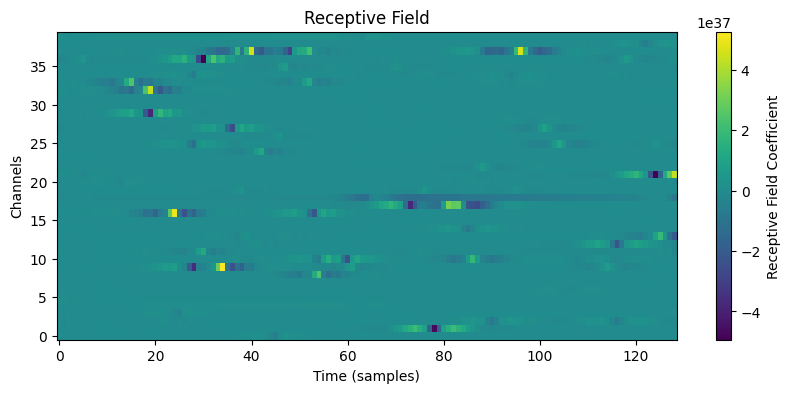

In [9]:
plt.figure(figsize=(10, 4))
plt.imshow(coef, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Receptive Field Coefficient')
plt.title('Receptive Field')
plt.xlabel('Time (samples)')
plt.ylabel('Channels')
plt.show()